Make sure you also have CudaToolKit installed on your computer
If not, you can access it here:
https://developer.nvidia.com/cuda-12-1-0-download-archive?target_os=Windows

In [1]:
# install influxdb client, just like for all the other database
#! pip install influxdb-client

# install tensorflow
#! pip install pytorch

How to find the data for the next block:

- find your token in: InfluxDBUI -> Load Data -> API TOKENS -> find your token/generate a token
- find your org: InfluxDBUI -> top left -> under your user name
- find your bucket: InfluxDBUI -> Load Data -> Buckets -> find your bucket/create a new bucket

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import datetime as dt
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd
import math


In [3]:

# You can generate a Token from the "Tokens Tab" in the UI
# replace your token, org, bucket here
token = "gQObTKL-jd4gKC0ShdiaB5lohG3JWlqQX4elYomvWj77uzZk7RRGN-oOfa_r97kp-QTJ2YYgCOW467BppoB9Pw=="
org = "DS4300 InfluxDB"
bucket = "DS4300 HW6"

## connect to influxdb
client = InfluxDBClient(url="http://localhost:8086", token=token, org = org)

In [4]:
# read the data
query_api = client.query_api()
tables = query_api.query("""from(bucket:"DS4300 HW6") |> range(start: -20y)
|> filter(fn: (r) => r["company"] == "Microsoft")
|> filter(fn: (r) => r["_measurement"] == "Stock_Price")
|> filter(fn: (r) => r["_field"] == "close")""")

In [5]:
# extract the features

# iterate over queried data
time, close = [], []
for table in tables:
    for row in table.records:
        time.append(row.values.get('_time'))
        close.append(row.values.get('_value'))

In [6]:
time = pd.to_datetime(time)

df = pd.DataFrame({
    'close': close
}, index=pd.to_datetime(time))  

In [7]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


In [12]:
# Split the data into train/test set
training_data_len = math.ceil(len(time) * .8)
 
#Splitting the dataset
train_data = df.close[:training_data_len].to_numpy().reshape(-1, 1)
test_data = df.close[training_data_len:].to_numpy().reshape(-1, 1)
print(train_data.shape, test_data.shape)

(1209, 1) (302, 1)


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(train_data)
 
print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(test_data)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test

[[0.0033909 ]
 [0.        ]
 [0.00993612]
 [0.00977841]
 [0.00891097]]
[0.28365428] [0.27635302] [0.28566213] [0.27032947] [0.24514009]


In [14]:
# Create sequences and labels for training data
sequence_length = 30 # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
	X_train.append(scaled_train[i:i+sequence_length])
	y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([1179, 30, 1]), torch.Size([1179, 30, 1]))

In [15]:
# Create sequences and labels for testing data
sequence_length = 30 # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
	X_test.append(scaled_test[i:i+sequence_length])
	y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape


(torch.Size([272, 30, 1]), torch.Size([272, 30, 1]))

In [16]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units 
	# num_layers : number of LSTM layers 
	def __init__(self, input_size, hidden_size, num_layers): 
		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.linear = nn.Linear(hidden_size, 1)

	def forward(self, x): # defines forward pass of the neural network
		out, _ = self.lstm(x)
		out = self.linear(out)
		return out


In [17]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [18]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0003, Test Loss: 0.0019
Epoch [20/50] - Training Loss: 0.0001, Test Loss: 0.0018
Epoch [30/50] - Training Loss: 0.0001, Test Loss: 0.0018
Epoch [40/50] - Training Loss: 0.0001, Test Loss: 0.0018
Epoch [50/50] - Training Loss: 0.0001, Test Loss: 0.0018


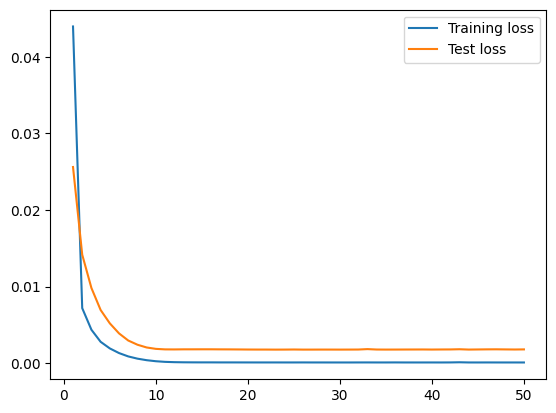

In [20]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


In [26]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(num_forecast_steps*2):
		# Prepare the historical_data tensor
		historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
		# Use the model to predict the next value
		predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

		# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value[0])

		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data[-1] = predicted_value

		
# Generate futute dates
test_data = df.close[training_data_len:]
last_date = test_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = df.close[training_data_len:].index.append(future_dates)


(30,)


C:\Users\chen.xi10\AppData\Local\Temp\ipykernel_109324\500447956.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


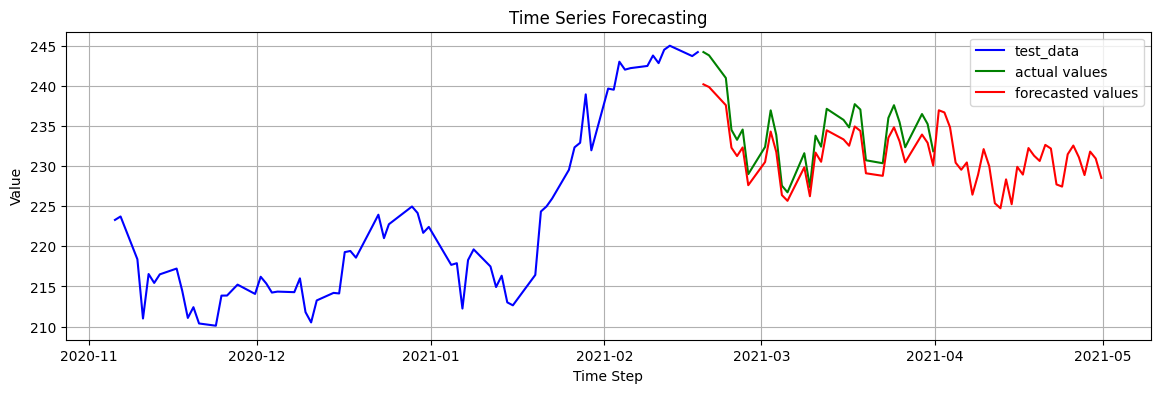

In [35]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 


#Test data
plt.plot(test_data.index[-100:-30], test_data.values[-100:-30], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 

#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red') 

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
